# FFNN (with raw features)

In [1]:
import sys
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from tensorflow.keras.models import save_model,load_model
from utils.preprocessing import *
from utils.dataset import Dataset

from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
import tensorflow.keras.backend as K
import core.config as conf

## Load Data & Preprocessing

In [2]:
ds = Dataset(train=True, target_encoding=False)

In [3]:
data_path = conf.raw_lzo_path + 'part-00000'
ori_df = read_data(data_path)

In [4]:
df = ds.preprocess(ori_df)

In [26]:
df.columns

Index(['language', 'creator_is_verified', 'media', 'engager_following_count',
       'engager_is_verified', 'creator_following_count', 'tweet_timestamp',
       'engager_account_creation', 'creator_account_creation', 'tweet_type',
       'creator_follows_engager', 'creator_follower_count', 'domains',
       'engager_follower_count', 'reply', 'retweet', 'comment', 'like',
       'dt_day', 'dt_dow', 'dt_hour', 'len_domains'],
      dtype='object')

In [5]:
df.head()

,engager_id,language,creator_is_verified,media,engager_following_count,engager_is_verified,creator_id,creator_following_count,tweet_timestamp,engager_account_creation,...,domains,engager_follower_count,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
0,2AEB7AFFD36CA43C0C963F24F75BCCAC,19,0,0,339,0,BC9980C5385A68894C2862F41884FB27,662,1613237034,1520886748,...,0,169,0.0,0.0,0.0,0.0,13,5,17,0
1,865C52D28FA84E5E233B530C6FDAECC2,46,1,0,1190,0,C0EBA033A5C0D2AD91B4500958E2C633,228,1613748600,1237570695,...,1,393,0.0,0.0,0.0,0.0,19,4,15,1
2,FE83E568BD4B2ACDBAF876CFBB6C7296,46,1,0,1473,0,03EA05E7440140ABF047BC216CE34917,3685,1613386238,1263176351,...,2,629,0.0,0.0,0.0,1.0,15,0,10,1
3,DB0201BF93E4CCA1B55932AC36923E43,46,1,0,200,0,2700B9E175757F126C082D6A5742787D,13511,1613708640,1268276559,...,0,123,0.0,0.0,0.0,0.0,19,4,4,0
4,04F45C4A769FE2D7C792A96C92342DC2,61,0,5,379,0,B7E441F2D886830FB3F0CE29CB35CB6B,720,1612586018,1483862063,...,0,134,0.0,0.0,0.0,1.0,6,5,4,0


In [6]:
df = df.drop('creator_id', axis=1)
df = df.drop('engager_id', axis=1)
df = df.drop('tweet_id', axis=1)

## Negative sampling

In [7]:
df_positive = df[df['like']==1]
df_negative = df[df['like']==0]
print(len(df_positive))
print(len(df_negative))

1207588
1826314


In [12]:
df_negative = df_negative.sample(n = len(df_positive))

In [13]:
df = pd.concat([df_positive, df_negative])

In [14]:
df_y = df[['reply', 'retweet', 'comment', 'like']]
df_x = df.drop(['reply', 'retweet', 'comment', 'like'], axis = 1)

## Scaling

In [15]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(df_x.values)

StandardScaler()

In [16]:
ss = standard_scaler.transform(df_x.values)

In [17]:
df_x = pd.DataFrame(ss, columns = df_x.columns)

In [18]:
X_train = df_x
y_train_like = df_y['like'].to_frame()

## data split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_like, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)

In [24]:
X_train

,language,creator_is_verified,media,engager_following_count,engager_is_verified,creator_following_count,tweet_timestamp,engager_account_creation,creator_account_creation,tweet_type,creator_follows_engager,creator_follower_count,domains,engager_follower_count,dt_day,dt_dow,dt_hour,len_domains
2294592,-1.208703,-0.465868,2.080211,-0.324858,-0.040341,-0.100779,-0.970044,0.904527,1.223261,0.731444,-0.873139,-0.143957,-0.152899,-0.071806,-0.992162,-1.484153,0.452926,-0.326148
553517,1.487844,-0.465868,-0.747824,-0.364726,-0.040341,-0.095221,-0.201151,0.990613,1.264820,0.731444,1.145293,-0.167145,-0.152899,-0.067189,-0.166415,1.015418,-0.727632,-0.326148
1046877,-0.732842,-0.465868,-0.747824,0.177603,-0.040341,-0.107280,0.248249,-1.020485,1.311620,-0.831618,1.145293,-0.167260,-0.152899,-0.009338,0.329032,-0.984239,-1.760619,-0.326148
986151,-0.732842,-0.465868,-0.747824,-0.302578,-0.040341,-0.107154,-1.047288,-0.076735,-0.440403,0.731444,1.145293,-0.167237,-0.152899,-0.065618,-0.992162,-1.484153,-1.170341,-0.326148
395592,-0.732842,-0.465868,-0.747824,-0.328375,-0.040341,-0.092929,1.581072,0.878991,-0.203434,-2.394681,1.145293,-0.167269,-0.152899,-0.063261,1.650226,-0.484325,-1.465480,-0.326148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968847,0.747615,-0.465868,-0.747824,-0.296129,-0.040341,-0.107405,1.504761,1.095003,1.319840,0.731444,1.145293,-0.167249,-0.152899,-0.063457,1.485077,-0.984239,0.452926,-0.326148
1855017,-0.098360,-0.465868,-0.433598,-0.340101,-0.040341,-0.040706,1.478456,0.565342,-1.123866,0.731444,1.145293,-0.166774,-0.152899,-0.067288,1.485077,-0.984239,-0.137353,-0.326148
1660043,-1.208703,-0.465868,-0.433598,-0.261537,-0.040341,-0.067085,-0.119146,0.591216,-1.240664,0.731444,-0.873139,-0.151435,-0.152899,-0.067975,-0.166415,1.015418,1.043204,-0.326148
1006235,-0.732842,2.146529,1.451758,0.678304,-0.040341,-0.085926,1.155014,-0.827900,-0.871864,0.731444,-0.873139,-0.133515,-0.152899,-0.046268,1.154779,1.515333,0.010217,-0.326148


## Model

In [20]:
model = Sequential([
    Dense(16, activation = 'relu', input_dim = X_test.shape[1]),
    Dense(8, activation = 'relu'),
    Dense(4, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [37]:
model = Sequential([
    Dense(128, activation = 'relu', input_dim = X_test.shape[1]),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [42]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy'])

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                

In [44]:
result = model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)

Epoch 1/30
60380/60380 [==============================] - 32s 526us/step - loss: 0.6341 - binary_crossentropy: 0.6341 - val_loss: 0.6364 - val_binary_crossentropy: 0.6364
Epoch 2/30
60380/60380 [==============================] - 32s 531us/step - loss: 0.6332 - binary_crossentropy: 0.6332 - val_loss: 0.6351 - val_binary_crossentropy: 0.6351
Epoch 3/30
60380/60380 [==============================] - 31s 521us/step - loss: 0.6329 - binary_crossentropy: 0.6329 - val_loss: 0.6340 - val_binary_crossentropy: 0.6340
Epoch 4/30
60380/60380 [==============================] - 31s 521us/step - loss: 0.6317 - binary_crossentropy: 0.6317 - val_loss: 0.6338 - val_binary_crossentropy: 0.6338
Epoch 5/30
60380/60380 [==============================] - 32s 528us/step - loss: 0.6318 - binary_crossentropy: 0.6318 - val_loss: 0.6325 - val_binary_crossentropy: 0.6325
Epoch 6/30
60380/60380 [==============================] - 32s 533us/step - loss: 0.6311 - binary_crossentropy: 0.6311 - val_loss: 0.6331 - val_bi

## Evaluate

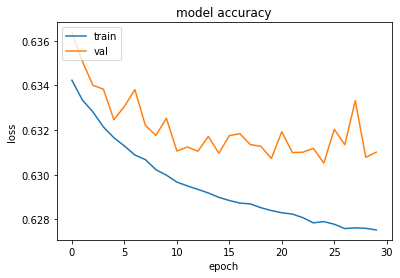

In [45]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
model.evaluate(X_test, y_test)

12076/12076 [==============================] - 6s 513us/step - loss: 0.6311 - binary_crossentropy: 0.6311


[0.6310710310935974, 0.6310710310935974]

In [47]:
pred = model.predict(X_test)

In [48]:
rce = compute_rce(pred, y_test['like'])
rce

/home/hyez/anaconda3/envs/dask-cudf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2279: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/hyez/anaconda3/envs/dask-cudf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2279: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


nan

In [49]:
average_precision_score(y_test['like'], pred)

0.6745239015865386